In [1]:
import json
import pandas as pd
from pathlib import Path
from pprint import pprint
import datetime
import time
import numpy as np
import matplotlib as plt

import pandas
import researchpy as rp
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

%matplotlib inline

In [2]:
#path_results = Path('/media/discoD/models/elmo/ner/results_20_epochs_ibm')
#path_results = Path('/media/discoD/models/elmo/ner/results_1_epoch_harem_all_combinations')
path_results = Path('/media/discoD/models/elmo/ner/results_datalawyer_all_reps')

In [3]:
for folder in path_results.iterdir():
    print(folder)

/media/discoD/models/elmo/ner/results_datalawyer_all_reps/datalawyer_ELMo
/media/discoD/models/elmo/ner/results_datalawyer_all_reps/datalawyer_ELMo+CNN
/media/discoD/models/elmo/ner/results_datalawyer_all_reps/datalawyer_ELMo+CNN+Embeddings
/media/discoD/models/elmo/ner/results_datalawyer_all_reps/datalawyer_ELMo+Embeddings


In [4]:
configs = dict()
metrics = dict()
for folder in path_results.iterdir():
    results_model_folder = folder.iterdir()
    for training_folder in results_model_folder:
        #print('Reading files from %s' % training_folder.name)
        has_metrics = False
        for results_file in training_folder.iterdir():
            if results_file.name.endswith('.json'):
                #print('Parsing data from %s' % results_file.name)
                if results_file.name.startswith('config'):
                    configs[training_folder.name] = json.loads(results_file.read_bytes())
                elif results_file.name.startswith('metrics.'):
                    metrics[training_folder.name] = json.loads(results_file.read_bytes())
                    has_metrics = True
        if not has_metrics:
            print('metrics.json not found for %s' % training_folder.name)
            del configs[training_folder.name]
print(len(metrics))
print(len(configs))

16
16


In [5]:
def get_seconds(time_str):
    x = time.strptime(time_str,'%H:%M:%S')
    return datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds()
def get_average_epoch_duration(metrics):
    seconds = get_seconds(metrics['training_duration'])
    training_epochs = metrics['training_epochs'] + 1
    return seconds / training_epochs

In [6]:
TRAINING_ID = 'Training_ID'
SCENARIO = 'Scenario'
MODEL = 'Model'
REPRESENTATION = 'Representation'
EMBEDDING = 'Embedding'
EMBEDDING_TYPE = 'Embedding_Type'
BATCH_SIZE = 'Batch_Size'
ELMO_DROPOUT = 'ELMo_Dropout'
TRAINING_NUMBER = 'Training_Number'
EXECUTION_NUMBER = 'Execution_Number'
BEST_EPOCH = 'Best_Epoch'
TRAINING_EPOCHS = 'Training_Epochs'
TRAINING_DURATION = 'Training_Duration'
TOTAL_DURATION = 'Total_Duration(s)'
AVERAGE_EPOCH_DURATION = 'Average_Epoch_Duration(s)'
TRAINING_ACCURACY = 'Training_Accuracy'
TRAINING_ACCURACY_TOP3 = 'Training_Accuracy_Top-3'
TRAINING_PRECISION = 'Training_Precision'
TRAINING_RECALL = 'Training_Recall'
TRAINING_F1_MEASURE = 'Training_F1-Measure'
TRAINING_LOSS = 'Training_Loss'
BEST_VALIDATION_ACCURACY = 'Best_Validation_Accuracy'
BEST_VALIDATION_ACCURACY_TOP3 = 'Best_Validation_Accuracy_Top-3'
BEST_VALIDATION_PRECISION = 'Best_Validation_Precision'
BEST_VALIDATION_RECALL = 'Best_Validation_Recall'
BEST_VALIDATION_F1_MEASURE = 'Best_Validation_F1-Measure'
BEST_VALIDATION_LOSS = 'Best_Validation_Loss'
TEST_ACCURACY = 'Test_Accuracy'
TEST_ACCURACY_TOP3 = 'Test_Accuracy_Top-3'
TEST_PRECISION = 'Test_Precision'
TEST_RECALL = 'Test_Recall'
TEST_F1_MEASURE = 'Test_F1_Measure'
TEST_LOSS = 'Test_Loss'
columns = [TRAINING_ID, MODEL, REPRESENTATION, EMBEDDING, EMBEDDING_TYPE, TRAINING_NUMBER, EXECUTION_NUMBER, BEST_EPOCH, TRAINING_EPOCHS, TRAINING_DURATION, TOTAL_DURATION, AVERAGE_EPOCH_DURATION, TRAINING_ACCURACY, TRAINING_ACCURACY_TOP3, TRAINING_PRECISION, TRAINING_RECALL, TRAINING_F1_MEASURE, TRAINING_LOSS, BEST_VALIDATION_ACCURACY, BEST_VALIDATION_ACCURACY_TOP3, BEST_VALIDATION_PRECISION, BEST_VALIDATION_RECALL, BEST_VALIDATION_F1_MEASURE, BEST_VALIDATION_LOSS, TEST_ACCURACY, TEST_ACCURACY_TOP3, TEST_PRECISION, TEST_RECALL, TEST_F1_MEASURE, TEST_LOSS]
columns

['Training_ID',
 'Model',
 'Representation',
 'Embedding',
 'Embedding_Type',
 'Training_Number',
 'Execution_Number',
 'Best_Epoch',
 'Training_Epochs',
 'Training_Duration',
 'Total_Duration(s)',
 'Average_Epoch_Duration(s)',
 'Training_Accuracy',
 'Training_Accuracy_Top-3',
 'Training_Precision',
 'Training_Recall',
 'Training_F1-Measure',
 'Training_Loss',
 'Best_Validation_Accuracy',
 'Best_Validation_Accuracy_Top-3',
 'Best_Validation_Precision',
 'Best_Validation_Recall',
 'Best_Validation_F1-Measure',
 'Best_Validation_Loss',
 'Test_Accuracy',
 'Test_Accuracy_Top-3',
 'Test_Precision',
 'Test_Recall',
 'Test_F1_Measure',
 'Test_Loss']

In [7]:
def get_training_data_from_id(training_id, config):
    data = training_id.split('_')
    print(data)
    if len(data) == 3:
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: 'No', EMBEDDING_TYPE: 'No', EXECUTION_NUMBER: data[2]}
    elif len(data) == 4:
        #GloVe
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: 'No', EXECUTION_NUMBER: data[3]}
    elif len(data) == 5:
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: data[3], EXECUTION_NUMBER: data[4]}
    else:
        print('Check id: %s' % training_id)

In [8]:
training_data = []
for training_id, config in configs.items():
    training_metrics = metrics[training_id]
    data = get_training_data_from_id(training_id, config)
    data[TRAINING_ID] = training_id
    data[BEST_EPOCH] = training_metrics['best_epoch'] if training_metrics else None
    data[TRAINING_EPOCHS] = training_metrics['training_epochs'] + 1 if training_metrics else None
    data[TRAINING_DURATION] = training_metrics['training_duration'] if training_metrics else None
    data[TOTAL_DURATION] = get_seconds(training_metrics['training_duration']) if training_metrics else None
    data[AVERAGE_EPOCH_DURATION] = get_average_epoch_duration(training_metrics) if training_metrics else None
    data[TRAINING_ACCURACY] = training_metrics['training_accuracy'] if training_metrics else None
    data[TRAINING_ACCURACY_TOP3] = training_metrics['training_accuracy3'] if training_metrics else None
    data[TRAINING_PRECISION] = training_metrics['training_precision-overall'] if training_metrics else None
    data[TRAINING_RECALL] = training_metrics['training_recall-overall'] if training_metrics else None
    data[TRAINING_F1_MEASURE] = training_metrics['training_f1-measure-overall'] if training_metrics else None
    data[TRAINING_LOSS] = training_metrics['training_loss'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY] = training_metrics['best_validation_accuracy'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY_TOP3] = training_metrics['best_validation_accuracy3'] if training_metrics else None
    data[BEST_VALIDATION_PRECISION] = training_metrics['best_validation_precision-overall'] if training_metrics else None
    data[BEST_VALIDATION_RECALL] = training_metrics['best_validation_recall-overall'] if training_metrics else None
    data[BEST_VALIDATION_F1_MEASURE] = training_metrics['best_validation_f1-measure-overall'] if training_metrics else None
    data[BEST_VALIDATION_LOSS] = training_metrics['best_validation_loss'] if training_metrics else None
    data[TEST_ACCURACY] = training_metrics['test_accuracy'] if training_metrics else None
    data[TEST_ACCURACY_TOP3] = training_metrics['test_accuracy3'] if training_metrics else None
    data[TEST_PRECISION] = training_metrics['test_precision-overall'] if training_metrics else None
    data[TEST_RECALL] = training_metrics['test_recall-overall'] if training_metrics else None
    data[TEST_F1_MEASURE] = training_metrics['test_f1-measure-overall'] if training_metrics else None
    data[TEST_LOSS] = training_metrics['test_loss'] if training_metrics else None
    training_data.append(data)

['datalawyer', 'ELMo', '0']
['datalawyer', 'ELMo+CNN', '0']
['datalawyer', 'ELMo+CNN+Embeddings', 'fasttext', 'cbow', '0']
['datalawyer', 'ELMo+CNN+Embeddings', 'fasttext', 'skip', '0']
['datalawyer', 'ELMo+CNN+Embeddings', 'glove', '0']
['datalawyer', 'ELMo+CNN+Embeddings', 'wang2vec', 'cbow', '0']
['datalawyer', 'ELMo+CNN+Embeddings', 'wang2vec', 'skip', '0']
['datalawyer', 'ELMo+CNN+Embeddings', 'word2vec', 'cbow', '0']
['datalawyer', 'ELMo+CNN+Embeddings', 'word2vec', 'skip', '0']
['datalawyer', 'ELMo+Embeddings', 'fasttext', 'cbow', '0']
['datalawyer', 'ELMo+Embeddings', 'fasttext', 'skip', '0']
['datalawyer', 'ELMo+Embeddings', 'glove', '0']
['datalawyer', 'ELMo+Embeddings', 'wang2vec', 'cbow', '0']
['datalawyer', 'ELMo+Embeddings', 'wang2vec', 'skip', '0']
['datalawyer', 'ELMo+Embeddings', 'word2vec', 'cbow', '0']
['datalawyer', 'ELMo+Embeddings', 'word2vec', 'skip', '0']


In [9]:
pd.set_option('display.max_columns', 1000)
training_data_df = pd.DataFrame(training_data, columns=columns)
training_data_df

,Training_ID,Model,Representation,Embedding,Embedding_Type,Training_Number,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss
0,datalawyer_ELMo_0,datalawyer,ELMo,No,No,NaN,0,9,20,01:19:11,4751.0,237.55,0.995505,0.995716,0.947154,0.948082,0.947617,7.205635,0.986646,0.986924,0.876652,0.899096,0.887732,31.179880,0.985337,0.985936,0.836750,0.863636,0.849981,38.576710
1,datalawyer_ELMo+CNN_0,datalawyer,ELMo+CNN,No,No,NaN,0,15,20,01:28:21,5301.0,265.05,0.995547,0.995735,0.950563,0.951184,0.950873,7.146722,0.988921,0.989291,0.886567,0.894578,0.890555,27.061418,0.986763,0.987273,0.855162,0.869906,0.862471,36.932742
2,datalawyer_ELMo+CNN+Embeddings_fasttext_cbow_0,datalawyer,ELMo+CNN+Embeddings,fasttext,cbow,NaN,0,18,20,01:24:42,5082.0,254.10,0.992804,0.993169,0.921156,0.915592,0.918366,10.216480,0.988126,0.988403,0.880475,0.893072,0.886729,21.845847,0.985988,0.986464,0.844343,0.871473,0.857694,30.541501
3,datalawyer_ELMo+CNN+Embeddings_fasttext_skip_0,datalawyer,ELMo+CNN+Embeddings,fasttext,skip,NaN,0,17,20,01:23:49,5029.0,251.45,0.996350,0.996496,0.960595,0.959184,0.959889,6.060906,0.988755,0.989143,0.881268,0.899849,0.890462,34.289365,0.985689,0.986235,0.835616,0.860502,0.847876,47.217977
4,datalawyer_ELMo+CNN+Embeddings_glove_0,datalawyer,ELMo+CNN+Embeddings,glove,No,NaN,0,8,20,01:25:33,5133.0,256.65,0.996296,0.996442,0.959654,0.959184,0.959419,5.900657,0.987608,0.987978,0.883721,0.887048,0.885381,30.683137,0.985848,0.986411,0.851477,0.858150,0.854801,39.833593
5,datalawyer_ELMo+CNN+Embeddings_wang2vec_cbow_0,datalawyer,ELMo+CNN+Embeddings,wang2vec,cbow,NaN,0,11,20,01:26:26,5186.0,259.30,0.996634,0.996765,0.960281,0.959184,0.959732,5.755887,0.988329,0.988755,0.892587,0.888554,0.890566,31.656637,0.984844,0.985478,0.847826,0.855799,0.851794,43.417910
6,datalawyer_ELMo+CNN+Embeddings_wang2vec_skip_0,datalawyer,ELMo+CNN+Embeddings,wang2vec,skip,NaN,0,12,20,01:28:22,5302.0,265.10,0.996254,0.996400,0.955161,0.956408,0.955784,6.168577,0.988163,0.988459,0.881041,0.892319,0.886644,33.936836,0.985619,0.986076,0.843272,0.864420,0.853715,47.034464
7,datalawyer_ELMo+CNN+Embeddings_word2vec_cbow_0,datalawyer,ELMo+CNN+Embeddings,word2vec,cbow,NaN,0,14,20,01:28:48,5328.0,266.40,0.996773,0.996865,0.963562,0.962776,0.963169,5.374076,0.987959,0.988292,0.883808,0.887801,0.885800,29.865132,0.986094,0.986692,0.850850,0.862853,0.856809,40.349562
8,datalawyer_ELMo+CNN+Embeddings_word2vec_skip_0,datalawyer,ELMo+CNN+Embeddings,word2vec,skip,NaN,0,9,20,01:29:47,5387.0,269.35,0.996776,0.996957,0.961903,0.960490,0.961196,5.604898,0.987830,0.988181,0.890649,0.889307,0.889977,31.070444,0.986780,0.987397,0.855140,0.860502,0.857812,40.546589
9,datalawyer_ELMo+Embeddings_fasttext_cbow_0,datalawyer,ELMo+Embeddings,fasttext,cbow,NaN,0,15,20,01:21:41,4901.0,245.05,0.992857,0.993192,0.917198,0.915102,0.916149,11.220935,0.987959,0.988366,0.888054,0.890060,0.889056,25.840158,0.986745,0.987309,0.856923,0.873041,0.864907,32.920424


In [10]:
training_data_df.to_csv('training_data_20_epochs_mestrado_datalawyer_all_reps.csv', index=None)

In [11]:
str(datetime.timedelta(seconds=training_data_df[TOTAL_DURATION].mean()))

'1:24:59.562500'

In [12]:
default_exported_columns = ['mean', 'min', 'max', 'std']
renamed_columns = ['Contagem', 'F-Score', 'Desvio Padrão', 'Mínimo', '25%', '50%', '75%', 'Máximo']
exported_columns_names = ['F-Score', 'Mínimo', 'Máximo', 'Desvio Padrão']
model_map = {'harem-ft': 'Sim', 'harem': 'Não'}
representation_map = {'ELMo+CNN+Embeddings': 'ELMo+CNN+Vetor', 'ELMo+Embeddings': 'ELMo+Vetor'}
embedding_type_map = {'skip': 'Skip-Gram', 'No': 'Sem Vetor', 'cbow': 'CBoW'}
embedding_map = {'wang2vec': 'Wang2Vec', 'glove': 'GloVe', 'word2vec': 'Word2Vec', 'No': 'Sem Vetor', 'fasttext': 'FastText'}
replacements_map = {**model_map, **representation_map, **embedding_type_map, **embedding_map}

def get_group_csv(index_names, group_name, group_columns, target_value, index_map, dataframe=training_data_df, exported_columns=default_exported_columns):
    if type(index_names) == str:
        index_names = [index_names]
    group = dataframe.groupby(group_columns).describe()[target_value].sort_values(by='mean', ascending=False)
    for column in exported_columns:
        group[column] = group[column] * 100
    group.index.names = index_names
    group = group.rename(index=index_map)
    group.columns = renamed_columns
    group.to_csv('grupo_' + group_name + '_20_epochs_mestrado_datalawyer_all_reps.csv', columns=exported_columns_names, float_format = '%.2f%%')
    return group

In [13]:
get_group_csv('Ajuste Fino', MODEL, MODEL, TEST_F1_MEASURE, model_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Ajuste Fino,,,,,,,,
datalawyer,16.0,85.730995,0.495273,84.787645,0.854529,0.857528,0.860653,86.490683


In [14]:
get_group_csv('Representação', REPRESENTATION, REPRESENTATION, TEST_F1_MEASURE, representation_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Representação,,,,,,,,
ELMo+CNN,1.0,86.247086,NaN,86.247086,0.862471,0.862471,0.862471,86.247086
ELMo+Vetor,7.0,86.057220,0.350740,85.581755,0.858025,0.860047,0.863592,86.490683
ELMo+CNN+Vetor,7.0,85.435747,0.361164,84.787645,0.852755,0.854801,0.857252,85.781250
ELMo,1.0,84.998072,NaN,84.998072,0.849981,0.849981,0.849981,84.998072


In [15]:
get_group_csv('Tipo de Vetor', EMBEDDING_TYPE, EMBEDDING_TYPE, TEST_F1_MEASURE, embedding_type_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Tipo de Vetor,,,,,,,,
CBoW,6.0,85.761814,0.429162,85.179407,0.856065,0.857252,0.858439,86.490683
Skip-Gram,6.0,85.732516,0.601903,84.787645,0.854627,0.857588,0.862035,86.374134
Sem Vetor,4.0,85.682486,0.557367,84.998072,0.853596,0.857424,0.860653,86.247086


In [16]:
get_group_csv('Vetor', EMBEDDING, EMBEDDING, TEST_F1_MEASURE, embedding_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Vetor,,,,,,,,
FastText,4.0,85.848000,0.772417,84.787645,0.855239,0.860568,0.863809,86.490683
GloVe,2.0,85.742392,0.370946,85.480094,0.856112,0.857424,0.858735,86.004691
Wang2Vec,4.0,85.698446,0.535983,85.179407,0.853235,0.856201,0.859951,86.374134
Word2Vec,4.0,85.695049,0.085952,85.581755,0.856561,0.857086,0.857475,85.781250
Sem Vetor,2.0,85.622579,0.883187,84.998072,0.853103,0.856226,0.859348,86.247086


In [17]:
get_group_csv(['Ajuste Fino', 'Representação', 'Vetor', 'Tipo de Vetor'], 'Model_Rep_Emb_Emb-Typ', [MODEL, REPRESENTATION, EMBEDDING, EMBEDDING_TYPE], TEST_F1_MEASURE, replacements_map)

Contagem    F-Score  \
Ajuste Fino Representação  Vetor     Tipo de Vetor                        
datalawyer  ELMo+Vetor     FastText  CBoW                1.0  86.490683   
                           Wang2Vec  Skip-Gram           1.0  86.374134   
                           FastText  Skip-Gram           1.0  86.344294   
            ELMo+CNN       Sem Vetor Sem Vetor           1.0  86.247086   
            ELMo+Vetor     GloVe     Sem Vetor           1.0  86.004691   
                           Wang2Vec  CBoW                1.0  85.868726   
            ELMo+CNN+Vetor Word2Vec  Skip-Gram           1.0  85.781250   
                           FastText  CBoW                1.0  85.769379   
            ELMo+Vetor     Word2Vec  Skip-Gram           1.0  85.736255   
            ELMo+CNN+Vetor Word2Vec  CBoW                1.0  85.680934   
            ELMo+Vetor     Word2Vec  CBoW                1.0  85.581755   
            ELMo+CNN+Vetor GloVe     Sem Vetor           1.0  85.480094   
                           Wang2Vec  Skip-Gram           1.0  85.371517   
                                     CBoW                1.0  85.179407   
            ELMo           Sem Vetor Sem Vetor           1.0  84.998072   
            ELMo+CNN+Vetor FastText  Skip-Gram           1.0  84.787645   

                                                    Desvio Padrão     Mínimo  \
Ajuste Fino Representação  Vetor     Tipo de Vetor                             
datalawyer  ELMo+Vetor     FastText  CBoW                     NaN  86.490683   
                           Wang2Vec  Skip-Gram                NaN  86.374134   
                           FastText  Skip-Gram                NaN  86.344294   
            ELMo+CNN       Sem Vetor Sem Vetor                NaN  86.247086   
            ELMo+Vetor     GloVe     Sem Vetor                NaN  86.004691   
                           Wang2Vec  CBoW                     NaN  85.868726   
            ELMo+CNN+Vetor Word2Vec  Skip-Gram                NaN  85.781250   
                           FastText  CBoW                     NaN  85.769379   
            ELMo+Vetor     Word2Vec  Skip-Gram                NaN  85.736255   
            ELMo+CNN+Vetor Word2Vec  CBoW                     NaN  85.680934   
            ELMo+Vetor     Word2Vec  CBoW                     NaN  85.581755   
            ELMo+CNN+Vetor GloVe     Sem Vetor                NaN  85.480094   
                           Wang2Vec  Skip-Gram                NaN  85.371517   
                                     CBoW                     NaN  85.179407   
            ELMo           Sem Vetor Sem Vetor                NaN  84.998072   
            ELMo+CNN+Vetor FastText  Skip-Gram                NaN  84.787645   

                                                         25%       50%  \
Ajuste Fino Representação  Vetor     Tipo de Vetor                       
datalawyer  ELMo+Vetor     FastText  CBoW           0.864907  0.864907   
                           Wang2Vec  Skip-Gram      0.863741  0.863741   
                           FastText  Skip-Gram      0.863443  0.863443   
            ELMo+CNN       Sem Vetor Sem Vetor      0.862471  0.862471   
            ELMo+Vetor     GloVe     Sem Vetor      0.860047  0.860047   
                           Wang2Vec  CBoW           0.858687  0.858687   
            ELMo+CNN+Vetor Word2Vec  Skip-Gram      0.857812  0.857812   
                           FastText  CBoW           0.857694  0.857694   
            ELMo+Vetor     Word2Vec  Skip-Gram      0.857363  0.857363   
            ELMo+CNN+Vetor Word2Vec  CBoW           0.856809  0.856809   
            ELMo+Vetor     Word2Vec  CBoW           0.855818  0.855818   
            ELMo+CNN+Vetor GloVe     Sem Vetor      0.854801  0.854801   
                           Wang2Vec  Skip-Gram      0.853715  0.853715   
                                     CBoW           0.851794  0.851794   
            ELMo           Sem Vetor Sem Vetor      0.849981  0.849981   
  

In [18]:
training_data_df.groupby([EMBEDDING, EMBEDDING_TYPE]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,,count,mean,std,min,25%,50%,75%,max
Embedding,Embedding_Type,,,,,,,,
fasttext,cbow,2.0,0.861300,0.005100,0.857694,0.859497,0.861300,0.863104,0.864907
wang2vec,skip,2.0,0.858728,0.007090,0.853715,0.856222,0.858728,0.861235,0.863741
word2vec,skip,2.0,0.857588,0.000318,0.857363,0.857475,0.857588,0.857700,0.857812
glove,No,2.0,0.857424,0.003709,0.854801,0.856112,0.857424,0.858735,0.860047
word2vec,cbow,2.0,0.856313,0.000701,0.855818,0.856065,0.856313,0.856561,0.856809
No,No,2.0,0.856226,0.008832,0.849981,0.853103,0.856226,0.859348,0.862471
fasttext,skip,2.0,0.855660,0.011007,0.847876,0.851768,0.855660,0.859551,0.863443
wang2vec,cbow,2.0,0.855241,0.004874,0.851794,0.853517,0.855241,0.856964,0.858687


In [19]:
training_data_skip_df = training_data_df[training_data_df[EMBEDDING_TYPE] != 'cbow']
training_data_skip_df.groupby([EMBEDDING]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding,,,,,,,,
wang2vec,2.0,0.858728,0.007090,0.853715,0.856222,0.858728,0.861235,0.863741
word2vec,2.0,0.857588,0.000318,0.857363,0.857475,0.857588,0.857700,0.857812
glove,2.0,0.857424,0.003709,0.854801,0.856112,0.857424,0.858735,0.860047
No,2.0,0.856226,0.008832,0.849981,0.853103,0.856226,0.859348,0.862471
fasttext,2.0,0.855660,0.011007,0.847876,0.851768,0.855660,0.859551,0.863443


In [20]:
training_data_cbow_df = training_data_df[training_data_df[EMBEDDING_TYPE] != 'skip']
training_data_cbow_df.groupby([EMBEDDING]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding,,,,,,,,
fasttext,2.0,0.861300,0.005100,0.857694,0.859497,0.861300,0.863104,0.864907
glove,2.0,0.857424,0.003709,0.854801,0.856112,0.857424,0.858735,0.860047
word2vec,2.0,0.856313,0.000701,0.855818,0.856065,0.856313,0.856561,0.856809
No,2.0,0.856226,0.008832,0.849981,0.853103,0.856226,0.859348,0.862471
wang2vec,2.0,0.855241,0.004874,0.851794,0.853517,0.855241,0.856964,0.858687


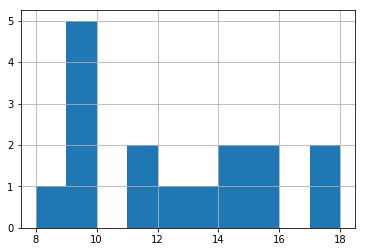

In [21]:
training_data_df[BEST_EPOCH].hist()

In [22]:
training_data_df[TOTAL_DURATION].describe()

count      16.000000
mean     5099.562500
std       223.381578
min      4751.000000
25%      4890.000000
50%      5096.500000
75%      5301.250000
max      5497.000000
Name: Total_Duration(s), dtype: float64

In [23]:
training_data_df.groupby([EXECUTION_NUMBER]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Execution_Number,,,,,,,,
0,16.0,0.85731,0.004953,0.847876,0.854529,0.857528,0.860653,0.864907


In [24]:
rp.summary_cont(training_data_df[TEST_F1_MEASURE])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Test_F1_Measure,16.0,0.85731,0.004953,0.001238,0.854671,0.859949


In [25]:
rp.summary_cont(training_data_df.groupby(EMBEDDING))[TEST_F1_MEASURE]

/home/pedro/anaconda3/envs/allennlp/lib/python3.6/site-packages/researchpy/summary.py:151: RuntimeWarning: invalid value encountered in sqrt
  l_ci = lambda x: numpy.mean(x) - (1.960 * (numpy.std(x)/numpy.sqrt(x.count() - 1)))
/home/pedro/anaconda3/envs/allennlp/lib/python3.6/site-packages/researchpy/summary.py:154: RuntimeWarning: invalid value encountered in sqrt
  u_ci = lambda x: numpy.mean(x) + (1.960 * (numpy.std(x)/numpy.sqrt(x.count() - 1)))


,N,Mean,SD,SE,95% Conf.,Interval
Embedding,,,,,,
No,2,0.856226,0.008832,0.006245,0.843985,0.868466
fasttext,4,0.858480,0.007724,0.003862,0.850910,0.866050
glove,2,0.857424,0.003709,0.002623,0.852283,0.862565
wang2vec,4,0.856984,0.005360,0.002680,0.851732,0.862237
word2vec,4,0.856950,0.000860,0.000430,0.856108,0.857793


In [26]:
# Calculating effect size
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    
    cols = ['sum_sq', 'mean_sq', 'df', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

def print_anova(parameter):
    # Fits the model with the interaction term
    # This will also automatically include the main effects for each factor
    model = ols('Test_F1_Measure ~ C({0})'.format(parameter), training_data_df).fit()
    # Seeing if the overall model is significant
    print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .20f}")
    print(model.summary())
    res = sm.stats.anova_lm(model, typ= 2)
    print(res)
    print(anova_table(res))
    mc = statsmodels.stats.multicomp.MultiComparison(training_data_df[TEST_F1_MEASURE], training_data_df[parameter])
    mc_results = mc.tukeyhsd()
    print(mc_results)

In [27]:
print_anova(EMBEDDING)

Overall model F( 4, 11) =  0.067, p =  0.99049980308096008397
                            OLS Regression Results                            
Dep. Variable:        Test_F1_Measure   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                 -0.331
Method:                 Least Squares   F-statistic:                   0.06733
Date:                Thu, 30 May 2019   Prob (F-statistic):              0.990
Time:                        08:36:51   Log-Likelihood:                 62.932
No. Observations:                  16   AIC:                            -115.9
Df Residuals:                      11   BIC:                            -112.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

/home/pedro/anaconda3/envs/allennlp/lib/python3.6/site-packages/scipy/stats/stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))
